# Calculating surface water area through time using JRC Water History 

**...and plotting alongside rainfall**


## Description

This notebook shows how to calculate the area of water in a catchment through time. Catchments are delineated using the 'HydroSheds' feature collection dataset.

This notebook is potentially also useful for extracting area from other products (easily adaptable).

Lastly, it shows how to plot rainfall on a second axis over an existing time-series, which can be a useful visualization technique.

## Load packages

Import Python packages that are used for the analysis.


In [1]:
%matplotlib inline

import ee
import eemont
import geemap as gmap
import geemap.colormaps as cm
import pandas as pd
import numpy as np
import seaborn as sb
import geopandas as gpd
from matplotlib import pyplot as plt

***

## Analysis Parameters

Some other catchment IDs

- lower_murray_id = 5050073410
- gwydir_namoi_macq_id = 5040524870
- lachlan_murrumm_id = 5040591050

In [2]:
#set the catchment ID to select a sub-basin (this is in the MDB)
catchment_id = 5040524870

#enter a name that we can for the plot title
catchment_name = 'Gywdir, Namoi & Macquarie'

#start and end dates of the analysis
start = '2010-01-01'
end = '2021-12-31'

# the pixel size to use, if hitting memory limits
# you can increase this number, but it will
# change the area calculated so be consistent
scale = 30

## Load catchments boundaries and select a sub-catchment

The dataset is here: https://developers.google.com/earth-engine/datasets/catalog/WWF_HydroSHEDS_v1_Basins_hybas_4

In [3]:
Map = gmap.Map(center=[-35.2041, 149.2721], zoom=5)
all_basins = ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_4")
Map.addLayer(all_basins, name='all basins')

# select a subbasin based on catchment ID
sub_basin = all_basins.filter(ee.Filter.eq('HYBAS_ID', catchment_id))
Map.addLayer(sub_basin, name='sub-basin')
Map

Map(center=[-35.2041, 149.2721], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(c…

## Load JRC water history

In [4]:
water = (ee.ImageCollection('JRC/GSW1_4/MonthlyHistory')
          .filterBounds(sub_basin) # filter to sub basin in the MDB
          .filterDate(start, end) 
          .select('water')
          .map(lambda image: image.clip(sub_basin)) #clip the data to MDB
)

## Calculate area through time

In [5]:
# Function for calculting area of water
def water_area_func(image):    
    thr=image.gt(1) # Threshold to create a binary image of water/no-water
    image = image.updateMask(thr) # update the mask of the image with thresholded mask
    area = ee.Image.pixelArea().divide(1e6) #create a raster of pixel area in sq km
    waterArea = image.multiply(area).rename('waterArea') # mulitply area raster by water/no-water image
    image = image.addBands(waterArea) # add the waterArea image back to the original image
    return image

#run the function over the Image Collection
waterArea = water.map(water_area_func)


## Extract time-series into dataframe and plot

In [6]:
#extract timeseries from GEE into a dataframe
df = waterArea.getTimeSeriesByRegion(geometry = sub_basin,
                              bands = ['waterArea'], #which bands are we summarising?
                              reducer = [ee.Reducer.sum()], #sum of area makes sense for water area
                              scale = scale)

# convert to a pandas dataframe
df = gmap.ee_to_pandas(df)

#convert date column to datetime
df['time'] = pd.to_datetime(df['date'],
                infer_datetime_format = True)

#make the index of dataframe the time stamps, and further clean up df
df = df.set_index('time').drop(['date', 'reducer'], axis=1)

df.head() #print the top 5 rows

,waterArea
time,
2010-01-01,1293.467091
2010-02-01,748.221325
2010-03-01,1204.579260
2010-04-01,1060.725130
2010-05-01,967.165128


### Plot using rolling mean to smooth time-series

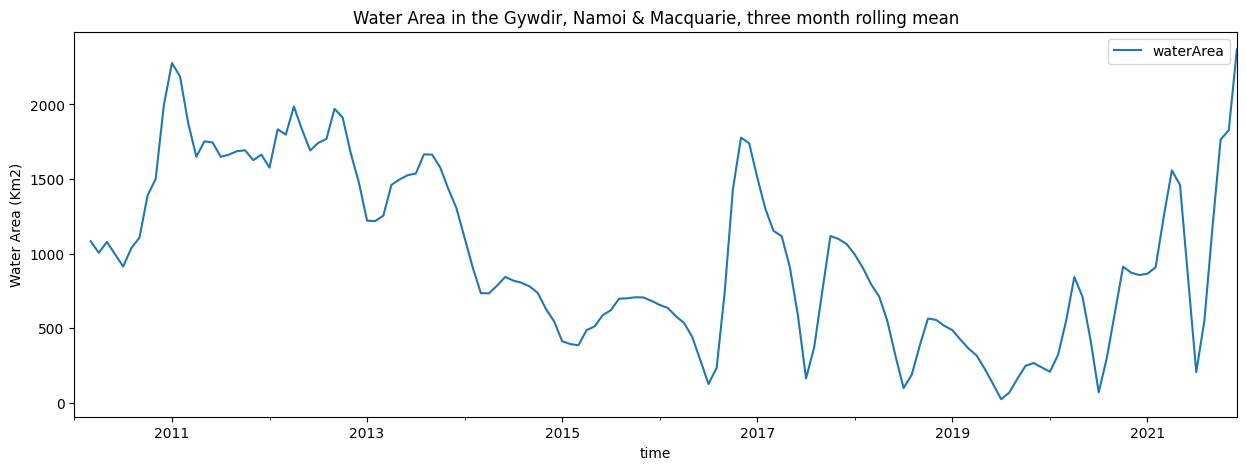

In [7]:
df.rolling(3).mean().plot(figsize=(15, 5))
plt.title('Water Area in the '+catchment_name+', three month rolling mean');
plt.ylabel('Water Area (Km2)');

## Load a rainfall dataset and summarise the same region 

CHIRPS is a good dataset:

Its has a daily version: https://developers.google.com/earth-engine/datasets/catalog/UCSB-CHG_CHIRPS_DAILY

And a 'pentad' (5 days) version: https://developers.google.com/earth-engine/datasets/catalog/UCSB-CHG_CHIRPS_PENTAD

In [8]:
rain = (ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
          .filterBounds(sub_basin) # filter to sub basin in the MDB
          .filterDate(start, end) #same dates as above
          .select('precipitation')
          .map(lambda image: image.clip(sub_basin)) #clip the data
)

In [9]:
#extract timeseries from GEE into a dataframe
df_rain = rain.getTimeSeriesByRegion(geometry = sub_basin,
                              bands = ['precipitation'], #which bands are we summarising?
                              reducer = [ee.Reducer.mean()], # mean of rainfall over region makes sense
                              scale = 5000 #resolution of CHIRPS
                                    )

# convert to a pandas dataframe
df_rain = gmap.ee_to_pandas(df_rain)

#convert date column to datetime
df_rain['time'] = pd.to_datetime(df_rain['date'],
                infer_datetime_format = True)

#make the index of dataframe the time stamps, and further clean up df
df_rain = df_rain.set_index('time').drop(['date', 'reducer'], axis=1)

df_rain.head() #print the top 5 rows

,precipitation
time,
2010-01-01,26.484557
2010-01-02,5.321299
2010-01-03,2.387393
2010-01-04,0.525157
2010-01-05,2.090538


## Resample CHIRPS to match the JRC water area temporal resolution

JRC is monthly and CHIRPS is daily, so we need to resample them so the temporal frequency matches. We also need to shift the dates in the water area dataset to the end of the month, which will match the datetimes in the rainfall dataset after we resample it. This is important if we want to plot on the same graph.

In [10]:
from pandas.tseries.offsets import MonthEnd

In [11]:
# Use the sum to aggregate daily rainfall into a monthly total.
# resample makes the datetime the end of the month by default
df_rain = df_rain.resample('M').sum()

#now shift the time index of the water area df to the end of the month
df.index = pd.to_datetime(df.index, format="%Y%m") + MonthEnd(0)

### Plot rainfall

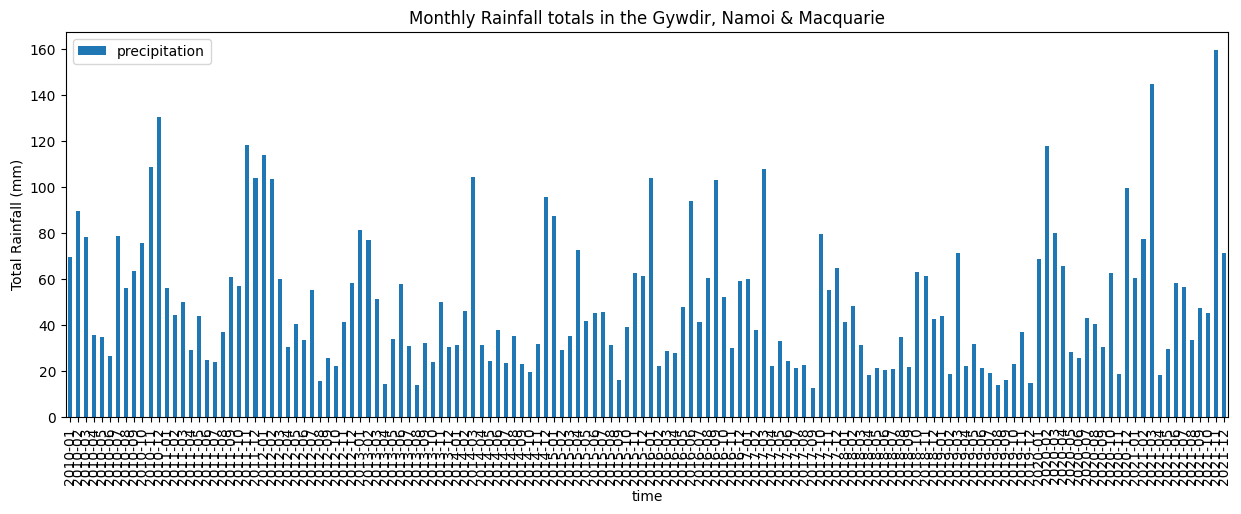

In [12]:
fig, ax = plt.subplots(figsize=(15,5))
df_rain.plot(ax=ax, kind='bar')
plt.title('Monthly Rainfall totals in the '+catchment_name);
ax.xaxis.set_ticklabels(df_rain.index.to_period('M'))
plt.ylabel('Total Rainfall (mm)');

## Combine rainfall and water area plot



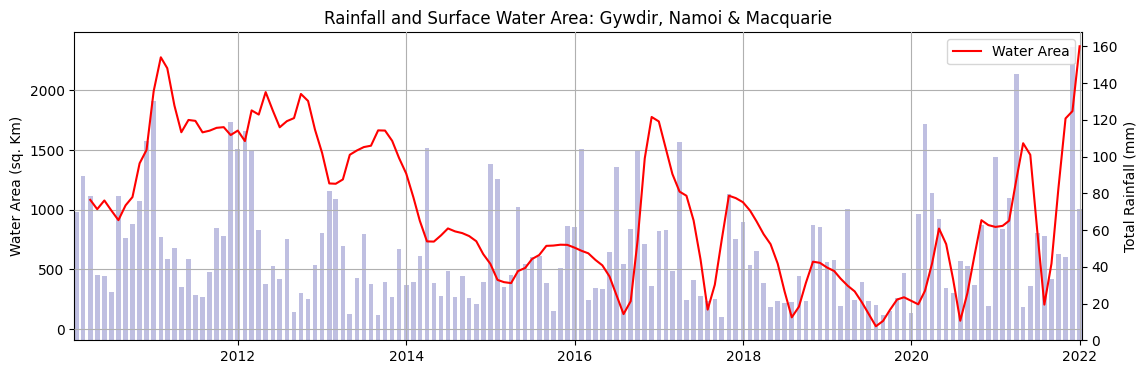

In [13]:
fig,ax = plt.subplots(1,1, figsize=(13,4))
ax2 = ax.twinx() 

#plot the bar graph and water area time-series
ax.plot(df.index, df.rolling(3).mean(), c='red')
ax2.bar(df_rain.index, df_rain['precipitation'], width=20, facecolor='darkblue', alpha=0.25)

#this makes the line plot on top of the bars
ax2.set_zorder(ax.get_zorder()-1)
ax.set_frame_on(False)
ax.legend(['Water Area'])

#tidy up plot
ax.set_ylabel('Water Area (sq. Km)')
ax.set_xlabel('')
ax2.set_ylabel('Total Rainfall (mm)')
ax.margins(x=0)
ax.grid(True)
ax2.margins(x=0)
plt.title('Rainfall and Surface Water Area: '+ catchment_name);


***